In [1]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy import linalg
import circle_fit as cf

(01)

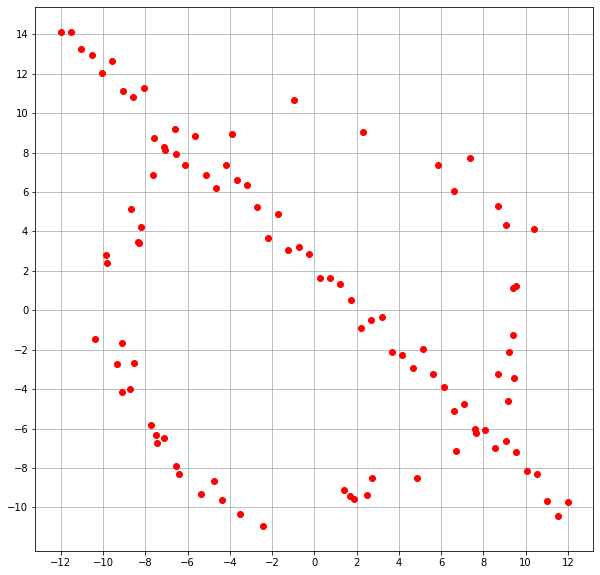

In [2]:
np.random.seed(0)
N = 100
half_n = N//2
r = 10
s = r/16
t = np.random.uniform(0 ,2*np.pi ,half_n)
n = s*np.random.randn(half_n)
x , y = (r + n)*np.cos(t), (r + n)*np.sin(t)
X_circ = np.hstack((x.reshape(half_n ,1), y.reshape(half_n ,1)))
m, b = -1, 2
x = np.linspace(-12,12 ,half_n)
y = m*x + b + s*np.random.randn(half_n)
X_line = np.hstack((x.reshape(half_n, 1),y.reshape(half_n , 1)))
X = np.vstack((X_circ ,X_line))

labelx = [-12,-10,-8,-6,-4,-2,0,2,4,6,8,10,12]
labely = [-10,-8,-6,-4,-2,0,2,4,6,8,10,12,14]
fig, ax = plt.subplots(1, 1, figsize=(10,10))
ax.plot(X[:,0], X[:,1], 'ro')
ax.set_xticks(labelx)
ax.set_yticks(labely)

plt.grid('on')
plt.show()

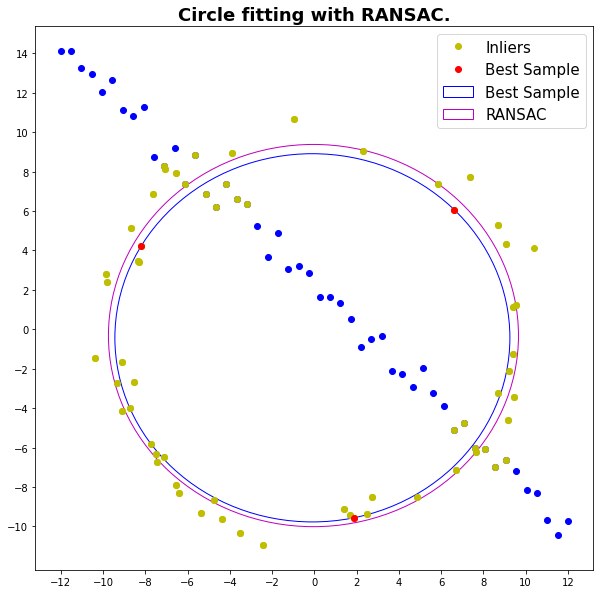

In [4]:
def est_circle(m, n, p):
    d_1 = ( (m[0] - n[0]) * (n[1] - p[1]) - (n[1] - m[1]) * (p[0] - n[0]) )
    d_2 = ( (m[0] - n[0]) * (n[1] - p[1]) - (n[1] - m[1]) * (p[0] - n[0]) )

    if d_1 != 0 and d_2 != 0:
        a = 0.5 * ( (n[1] - p[1]) * (m[0]**2 + m[1]**2 - n[0]**2 - n[1]**2) + (n[1] - m[1]) * (n[0]**2 + n[1]**2 - p[0]**2 - p[1]**2) ) / d_1
        b = 0.5 * ( (m[0] - n[0]) * (n[0]**2 + n[1]**2 - p[0]**2 - p[1]**2) + (p[0] - n[0]) * (m[0]**2 + m[1]**2 - n[0]**2 - n[1]**2) ) / d_2
        c = -p[0]**2 - p[1]**2 + 2*a*p[0] + 2*b*p[1]
        r = (a**2 + b**2 - c)**0.5

    return a, b, r

def draw_circle(m, n, p):
    a, b, r = est_circle(m, n, p)
    circle = plt.Circle((a, b), r, color='b', fill=False)
    return circle

def inlier_cnt(a, b, r, X, t):
    cnt = 0
    best_inliers = None

    for i in range(X.shape[0]):
        d = abs( ( (X[i,0] - a)**2 + (X[i,1] - b)**2 ) ** 0.5 - r )
        if d < t:
            cnt += 1
            if type(best_inliers) == type(None):
                best_inliers = np.array([X[i,:]])
            else:
                best_inliers = np.concatenate((best_inliers, X[i,:].reshape(1, -1)), axis=0)
    
    return cnt, best_inliers

def RANSAC_circle(X): 
    pts = 3
    t = 1.96
    d = 50
    N = 35

    best_circle = None
    best_x = None
    best_in_cnt = 0

    #Get random 3 points from data to estimate the circle
    
    for i in range(N):
        pt = []

        for j in range(pts):
            h_on = X[np.random.randint(0, 100), :]
            
            if len(pt) == 0:
                pt.append(h_on)
            elif np.array_equal(h_on, pt[-1]):                
                while np.array_equal(h_on, pt[-1]):
                    h_on = X[np.random.randint(0, 100), :]
                
                pt.append(h_on)
            else:
                pt.append(h_on)
        
        a, b, r = est_circle(pt[0], pt[1], pt[2])

        if a == None:
            continue

        cnt, inliers = inlier_cnt(a, b, r, X, t)
        
        #Draw ransac circle

        if cnt > best_in_cnt:
            best_circle = plt.Circle((a, b), r, color='b', fill=False, label="Best Sample")
            best_pt = pt
            best_inliers = inliers
            best_in_cnt = cnt

    xc,yc,r,_ = cf.least_squares_circle(best_inliers)

    #Draw least square circle
    
    ransac_circle = plt.Circle((xc, yc), r, color='m', fill=False, label="RANSAC")
    
    return ransac_circle, best_circle, best_pt, best_inliers

ransac_circle, best_circle, best_pt, best_inliers = RANSAC_circle(X)

fig, ax = plt.subplots(1, 1, figsize=(10,10))
ax.scatter(X_circ[:,0], X_circ[:,1], color="y")
ax.scatter(X_line[:,0], X_line[:,1], color="b")

for point in best_inliers:
    if np.array_equal(point, best_inliers[-1]):
        ax.plot(point[0], point[1], 'yo', label="Inliers")
    else:
        ax.plot(point[0], point[1], 'yo')


for point in best_pt:
    if np.array_equal(point, best_pt[-1]):
        ax.plot(point[0], point[1], 'ro', label="Best Sample")
    else:
        ax.plot(point[0], point[1], 'ro')
        
        
labelx = [-12,-10,-8,-6,-4,-2,0,2,4,6,8,10,12]
labely = [-10,-8,-6,-4,-2,0,2,4,6,8,10,12,14]
ax.add_patch(best_circle)
ax.add_patch(ransac_circle)
ax.set_title("Circle fitting with RANSAC.",fontweight ="bold",fontsize = 18)
ax.set_xticks(labelx)
ax.set_yticks(labely)
ax.legend(loc="upper right", prop={'size': 15})
plt.show()


(02)